# Dubins Car

The Dubins car problem is non-holonomic, and while each configuration is possible, the manner in which those configurations can be reached is reduced. Notably we have $$\dot y \cos \theta - \dot x \sin \theta = 0$$

For hybrid example, the car is expected to reach a destination while avoiding two obstacles.
There are two different dynamics on the road (dry and wet road), with different control limits.

In [64]:
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import dubins_nominal_hjr_control as nominal_hjr_control
import matplotlib
import matplotlib.animation as anim
import os
import logging

In [9]:
sys.path.insert(1, '../lib')
import refine_cbfs
import experiment_wrapper
import cbf_opt
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF

In [10]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '80',
    'text.usetex': False,   # Toggle to true for official LaTeX output
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})

params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

## Setup Problem (dynamics, environment and CBF)

### Parameter values

Dynamics properties

In [15]:
# original system cannot control velocity, we introduce acceleration in the new system.

use_new_system =  True # choose new system or not

dubins_vel = 1.0  # m / s 
if use_new_system:
    umin_dry = np.array([-0.5, -2.])  # rad / s and m^2 / s
    umax_dry = np.array([0.5, 2.]) 
    umin_wet = np.array([-0.2, -0.5])
    umax_wet = np.array([0.2, 0.5])
    file_name = '_new'
else:
    umin_dry = np.array([-0.5])  # rad / s
    umax_dry = np.array([0.5])
    file_name = ''
dt = 0.05 # s

Constraint set of the problem. Two rectangular constraints in the $(x,y)$ space

In [12]:
obstacle_center = np.array([[5.0, 5.0], [10.0, 5.0]])
obstacle_length = np.array([2.0, 2.0])

### Dynamics

Dynamics of the Dubins car problem (control affine) in the format of `cbf_opt`

`DubinsJNPDynamics` is required for usage with `hj_reachability` module

In [13]:
# old system with fixed velocity, not used

class DubinsDynamics(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']
    
    def __init__(self, params, test = False, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1
        params["periodic_dims"] = [2]
        self.v = params["v"]
        super().__init__(params, test, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = self.v * np.cos(state[..., 2])
        f[..., 1] = self.v * np.sin(state[..., 2])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 2, 0] = 1
        return B

    def disturbance_jacobian(self, state, time=0.0):
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 2] = -self.v * np.sin(state[..., 2])
        J[..., 1, 2] = self.v * np.cos(state[..., 2])
        return J
        
class DubinsJNPDynamics(DubinsDynamics):
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([self.v * jnp.cos(state[2]), self.v * jnp.sin(state[2]), 0])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, -self.v * jnp.sin(state[2])],
            [0, 0, self.v * jnp.cos(state[2])], 
            [0, 0, 0]])

In [14]:
# we are using this new system

class DubinsDynamicsNew(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA', 'VELOCITY']
    CONTROLS = ['OMEGA', 'ACCELERATION']
    
    def __init__(self, params, test = False, **kwargs):
        params['n_dims'] = 4
        params['control_dims'] = 2
        params["periodic_dims"] = [2]
        # self.v = params["v"]
        super().__init__(params, test, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = np.cos(state[..., 3]) * np.cos(state[..., 2])
        f[..., 1] = np.cos(state[..., 3]) * np.sin(state[..., 2])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 2, 0] = 1
        B[..., 3, 1] = 1
        return B

    def disturbance_jacobian(self, state, time=0.0):
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 2] = - np.cos(state[..., 3]) * np.sin(state[..., 2])
        J[..., 1, 2] = np.cos(state[..., 3]) * np.cos(state[..., 2])
        J[..., 0, 3] = - np.sin(state[..., 3]) * np.cos(state[..., 2])
        J[..., 1, 3] = - np.sin(state[..., 3]) * np.sin(state[..., 2])
        return J
        
class DubinsJNPDynamicsNew(DubinsDynamicsNew):
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([jnp.cos(state[3]) * jnp.cos(state[2]), jnp.cos(state[3]) * jnp.sin(state[2]), 0, 0])

    def control_matrix(self, state, time=0.0):
        return jnp.array([[0, 0], [0, 0], [1, 0], [0, 1]])

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(4), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, -jnp.cos(state[3]) * jnp.sin(state[2]), - jnp.sin(state[3]) * jnp.cos(state[2])],
            [0, 0, jnp.cos(state[3]) * jnp.cos(state[2]), - jnp.sin(state[3]) * jnp.sin(state[2])], 
            [0, 0, 0, 0],
            [0, 0, 0, 0]])

In [16]:
if use_new_system:
    dyn = DubinsDynamicsNew({"v": dubins_vel, "dt": dt}, test=True)
    dyn_jnp = DubinsJNPDynamicsNew({"v": dubins_vel, "dt": dt}, test=True)
else:
    dyn = DubinsDynamics({"v": dubins_vel, "dt": dt}, test=True)
    dyn_jnp = DubinsJNPDynamics({"v": dubins_vel, "dt": dt}, test=True)

### Constructing initial local CBFs

In [17]:
class DubinsCBF(ControlAffineCBF):
    def __init__(self, dynamics: DubinsDynamics, params: dict = dict(), **kwargs) -> None:
        self.center = params["center"]
        self.r = params["r"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        vf_value = (state[..., 0] - self.center[0]) ** 2 + (state[..., 1] - self.center[1]) ** 2 - self.r ** 2
        return vf_value

    def _grad_vf(self, state, time=0.0):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 0] = 2 * (state[..., 0] - self.center[0])
        dvf_dx[..., 1] = 2 * (state[..., 1] - self.center[1])
        return dvf_dx

In [21]:
# dry CBF and wet CBF

dubins_cbf_dry = DubinsCBF(dyn, {"center": obstacle_center[0, :], "r": np.sqrt(np.max(obstacle_length))}, test=True)
dubins_cbf_wet = DubinsCBF(dyn, {"center": obstacle_center[1, :], "r": np.sqrt(np.max(obstacle_length))}, test=True)

### Environment
Defining the discretized state space and the location of obstacles

In [22]:
dyn_hjr_dry = refine_cbfs.dynamics.HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(jnp.array(umin_dry), jnp.array(umax_dry)))
dyn_hjr_wet = refine_cbfs.dynamics.HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(jnp.array(umin_wet), jnp.array(umax_wet)))

low_bound = -5.
upp_bound = 20.
resolution_bound = int(201 / 4)

if use_new_system:
    state_domain = hj.sets.Box(lo=jnp.array([low_bound, low_bound, -jnp.pi, -5.]), hi=jnp.array([upp_bound, upp_bound, jnp.pi, 5.]))
    grid_resolution = (resolution_bound, resolution_bound, 41, 20)
    grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)
else:
    state_domain = hj.sets.Box(lo=jnp.array([low_bound, low_bound, -jnp.pi]), hi=jnp.array([upp_bound, upp_bound, jnp.pi]))
    grid_resolution = (resolution_bound, resolution_bound, 81)
    grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)    

In [35]:
def constraint_set(state):
    """A real-valued function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    length = obstacle_length
    bottom_left = jnp.array(obstacle_center[0, :] - obstacle_length / 2)
    value_dry_obstacle = - jnp.min(jnp.array([state[0] - bottom_left[0], bottom_left[0] + length[0] - state[0], 
                               state[1] - bottom_left[1], bottom_left[1] + length[1] - state[1]]))
    bottom_right = jnp.array(obstacle_center[1, :] - obstacle_length / 2)
    value_wet_obstacle = - jnp.min(jnp.array([state[0] - bottom_right[0], bottom_right[0] + length[0] - state[0], 
                               state[1] - bottom_right[1], bottom_right[1] + length[1] - state[1]]))
    
    return value_dry_obstacle, value_wet_obstacle

obstacle_dry, obstacle_wet = hj.utils.multivmap(constraint_set, jnp.arange(grid.ndim))(grid.states)  # constraint l(x)
obstacle_all = jnp.minimum(obstacle_dry, obstacle_wet)
assert obstacle_dry.shape == obstacle_wet.shape, "Double check the obstacles computation"

## Start to find valid local CBFs using Dynamic Programming

In [44]:
# time setup
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)

# data saving path
dataset_path = "../dataset/dubins_data"
if not os.path.isdir(dataset_path):
    os.makedirs(dataset_path)

In [43]:
# computing local dry CBF values, takes around 3 mins on desktop

# initialization
dubins_tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(dyn, dict(), grid=grid)
dubins_tabular_cbf_dry.tabularize_cbf(dubins_cbf_dry)

# backward reach setting
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings_dry = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle_dry))

# solving
init_value_dry = dubins_tabular_cbf_dry.vf_table 
target_values_hjr_dry = hj.solve(solver_settings_dry, dyn_hjr_dry, grid, times, obstacle_dry)
target_values_dry = hj.solve(solver_settings_dry, dyn_hjr_dry, grid, times, init_value_dry)

# saving
np.save(dataset_path + "/target_values_hjr_dry"+file_name+".npy", target_values_hjr_dry)
np.save(dataset_path + "/target_values_dry"+file_name+".npy", target_values_dry)

100%|##########| 10.0000/10.0 [01:39<00:00,  9.99s/sim_s]
100%|##########| 10.0000/10.0 [01:38<00:00,  9.90s/sim_s]


In [45]:
# computing local wet CBF values, takes around 2 mins on desktop

dubins_tabular_cbf_wet = refine_cbfs.TabularControlAffineCBF(dyn, dict(), grid=grid)
dubins_tabular_cbf_wet.tabularize_cbf(dubins_cbf_wet)

solver_settings_wet = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle_wet))
init_value_wet = dubins_tabular_cbf_wet.vf_table 

target_values_hjr_wet = hj.solve(solver_settings_wet, dyn_hjr_wet, grid, times, obstacle_wet)
target_values_wet = hj.solve(solver_settings_wet, dyn_hjr_wet, grid, times, init_value_wet)

np.save(dataset_path + "/target_values_hjr_wet"+file_name+".npy", target_values_hjr_wet)
np.save(dataset_path + "/target_values_wet"+file_name+".npy", target_values_wet)

100%|##########| 10.0000/10.0 [00:51<00:00,  5.10s/sim_s]
100%|##########| 10.0000/10.0 [00:49<00:00,  4.94s/sim_s]


In [46]:
# if you have computed values before, then just read them

target_values_wet = jnp.load(dataset_path + "/target_values_wet"+file_name+".npy")
target_values_hjr_wet = jnp.load(dataset_path + "/target_values_hjr_wet"+file_name+".npy")
target_values_dry = jnp.load(dataset_path + "/target_values_dry"+file_name+".npy")
target_values_hjr_dry = jnp.load(dataset_path + "/target_values_hjr_dry"+file_name+".npy")

In [47]:
# Now write computed CBF values in the 'refine_cbfs' format

tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_dry.vf_table = np.array(target_values_dry[-1])

tabular_cbf_wet = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_wet.vf_table = np.array(target_values_wet[-1])

In [50]:
# define switching conditions

switch_position = 8.0
switch_radius = .2
switch = abs(grid.states[..., 0] - switch_position) - switch_radius

# the intersection of safe dry and unsafe ice regions
unsafe_wet_values = target_values_dry * target_values_wet
safe_switch = jnp.maximum(switch, unsafe_wet_values[-1])
new_obstacle = jnp.minimum(safe_switch, target_values_dry[-1])

assert switch.shape == safe_switch.shape and switch.shape == new_obstacle.shape, "Double check the shapes of switching area and new obstacles"

# Start to refine the initial local dry CBF to be aware of safe switching

In [51]:
# initialization using initial dry CBF

refined_cbf = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
refined_cbf_jnp = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)

refined_cbf.vf_table = np.array(target_values_dry[-1])
refined_cbf_jnp.vf_table = target_values_dry[-1]

In [52]:
# solving, takes around 2 mins on desktop

solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(new_obstacle))
init_value_refine = refined_cbf.vf_table 
target_values_refined_dry = hj.solve(solver_settings, dyn_hjr_dry, grid, times, init_value_refine)

np.save(dataset_path + "/target_values_refined_dry"+file_name+".npy", target_values_refined_dry)

100%|##########| 10.0000/10.0 [01:40<00:00, 10.06s/sim_s]


In [71]:
# if you have computed values before, then just read them

target_values_refined_dry = jnp.load(dataset_path + "/target_values_refined_dry"+file_name+".npy")

refined_cbf_dry = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
refined_cbf_dry.vf_table = np.array(target_values_refined_dry[-1])

## Running the experiment

In [59]:
if use_new_system:
    x0 = np.array([2, 5, np.pi / 3, 0.]) # initial state
else:
    x0 = np.array([2, 4, np.pi / 3])
    
n_sims_per_start = 1
t_sim = 10 * 2.0
target_height = 4.
mid_target_position = 10.5
final_target_position = 12
assert switch_position < mid_target_position, "middle policy cannot be used since switching happends after middle target"

We use HJ reachability to setup the nominal controllers

In [57]:
# this is a nominal control to a middle point, but we will switch dynamics before reaching it, and then change nominal controller
# take around 1 mins on desktop

target_mid = np.array([mid_target_position , target_height, 0])

opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                  target=target_mid, padding=jnp.array([.2, .2, jnp.pi / 6]))

opt_ctrl.solve()
np.save(dataset_path + "/nom_ctrl_mid"+file_name+".npy", opt_ctrl.tv_vf)
nom_policy_tar_mid = nominal_hjr_control.NominalPolicy(opt_ctrl)

100%|##########| 30.0000/30.0 [00:54<00:00,  1.83s/sim_s]


In [60]:
# this is a nominal controller to the final position, takes around 1 min on desktop

target_final = np.array([final_target_position, target_height, 0])

opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                  target=target_final, padding=jnp.array([.2, .2, jnp.pi / 6]))

opt_ctrl.solve()
np.save(dataset_path + "/nom_ctrl_final"+file_name+".npy", opt_ctrl.tv_vf)
nom_policy_tar_final = nominal_hjr_control.NominalPolicy(opt_ctrl)

100%|##########| 30.0000/30.0 [00:53<00:00,  1.79s/sim_s]


In [82]:
# load policy data

opt_ctrl_mid = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                target=target_mid, padding=jnp.array([.2, .2, jnp.pi / 6]))
opt_ctrl_mid.tv_vf = jnp.load(dataset_path + "/nom_ctrl_mid"+file_name+".npy")

opt_ctrl_final = nominal_hjr_control.NominalControlHJNP(dyn_hjr_dry, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                target=target_final, padding=jnp.array([.2, .2, jnp.pi / 6]))
opt_ctrl_final.tv_vf = jnp.load(dataset_path + "/nom_ctrl_final"+file_name+".npy")

nom_policy_tar_mid = nominal_hjr_control.NominalPolicy(opt_ctrl_mid)
nom_policy_tar_final = nominal_hjr_control.NominalPolicy(opt_ctrl_final)   

### Setting up the safety filter

In [83]:
alpha = lambda x: 1. * x

dubins_asif_tar_dry_mid = ControlAffineASIF(dyn, dubins_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar_mid)
dubins_asif_ws_tar_dry_mid = ControlAffineASIF(dyn, tabular_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar_mid, umin=umin_dry, umax=umax_dry)

dubins_asif_tar_dry_final = ControlAffineASIF(dyn, dubins_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar_final)
dubins_asif_ws_tar_dry_final = ControlAffineASIF(dyn, tabular_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar_final, umin=umin_dry, umax=umax_dry)

dubins_asif_tar_wet_final = ControlAffineASIF(dyn, dubins_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar_final)
dubins_asif_ws_tar_wet_final = ControlAffineASIF(dyn, tabular_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar_final, umin=umin_wet, umax=umax_wet)

# dubins_asif_global_dry = ControlAffineASIF(dyn, dubins_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar_final)
# dubins_asif_ws_global_dry = ControlAffineASIF(dyn, tabular_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar_final, umin=umin_dry, umax=umax_dry)

# dubins_asif_global_wet = ControlAffineASIF(dyn, dubins_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar_final)
# dubins_asif_ws_global_wet = ControlAffineASIF(dyn, tabular_cbf_wet, alpha=alpha, nominal_policy=nom_policy_tar_final, umin=umin_wet, umax=umax_wet)

dubins_asif_ws_refined_mid = ControlAffineASIF(dyn, refined_cbf_dry, alpha=alpha, nominal_policy=nom_policy_tar_mid, umin=umin_dry, umax=umax_dry)


### Rollout different CBFs / nominal controller

In [ ]:
experiment = RolloutTrajectory('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
use_hybrid_mode = True

# run the results, takes around 5 mins on desktop

logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings

results_df_hybrid, jump_state, traj_all = experiment.run_hybrid_dubins(dyn, 
                                                                       {'Nominal': nom_policy_tar_mid, 
                                                                        'Baseline': dubins_asif_ws_tar_dry_mid, 
                                                                        'Refined': dubins_asif_ws_refined_mid}, 
                                                                       {'Nominal': nom_policy_tar_final, 
                                                                        'Baseline': dubins_asif_ws_tar_wet_final, 
                                                                        'Refined': dubins_asif_ws_tar_wet_final}, 
                                                                        switch_position)
results_df = results_df_hybrid.copy()

### Visualizing the results

In [85]:
ts_experiment = TimeSeriesExperiment('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment = StateSpaceExperiment('dubins', x_indices=[0, 1], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [86]:
updated_df = results_df.copy()
for ctrl in updated_df.controller.unique():
    df = updated_df[(updated_df.controller == ctrl) & (updated_df.measurement == 'dist_to_goal')]
    min_val = df.value.min()
    t_min = df.t.loc[df.value == df.value.min()].values[0]
    condition = updated_df[(updated_df.controller == ctrl) & (updated_df.t > t_min)]
    updated_df = updated_df.drop(condition.index)
updated_df = updated_df.reset_index(drop=True)

### Figure in paper

In [87]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.2, 0.2, 0.2))
chosen_colors.append((0.7, 0.7, 0.7))

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]

alt_colors = sns.color_palette("pastel", 9).as_hex()

In [88]:
save_figure = True
offset = 0

# to visualize switching areas
surface_values = target_values_hjr_dry[-1][..., offset]
index_switch = int((switch_position - low_bound) / (upp_bound - low_bound) * resolution_bound)
rest_index = resolution_bound - index_switch
surface_values = jnp.concatenate((- jnp.ones((resolution_bound, index_switch)), jnp.ones((resolution_bound, rest_index))), axis=1)

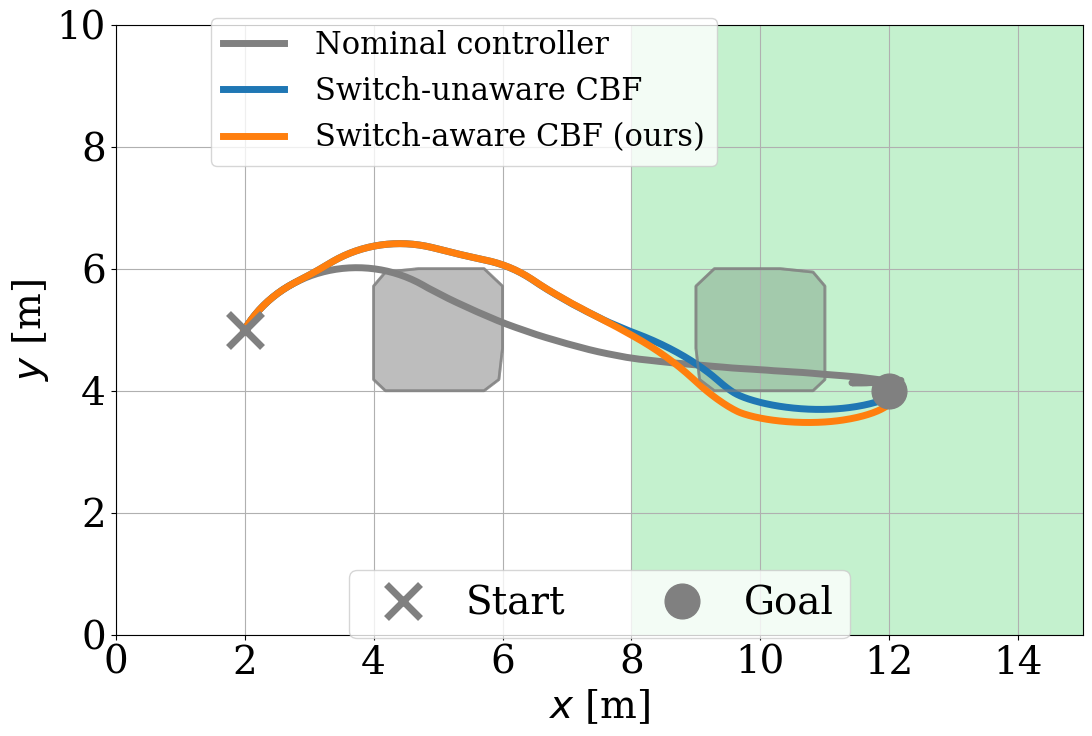

In [90]:
fig_comb, axs = plt.subplots(1, 1, figsize=(12, 8), sharey=True)
proxy = [] 
ax=axs

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., offset, offset].T, 
                 levels=[-10, 0], alpha=0.3, colors='grey')
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., offset, offset].T, 
           levels=[0], alpha=0.6, colors='grey', linewidths=2)
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], surface_values, 
                 levels=[0, 50], colors=alt_colors[2], alpha=0.3)

ax.grid()
ax.set_xlabel("$x$ [m]")
ax.set_ylabel('$y$ [m]')
ax.set_xlim([0, 15])
ax.set_ylim([0, 10])
ax = axs
ss_experiment.plot(dyn, updated_df, ax=ax, color=chosen_colors, add_direction=False)
ax.grid(True)
ax.set_xlim([0, 15])
ax.set_ylim([0, 10])
pal = sns.color_palette("colorblind")
sns.set_palette("colorblind")

l1 = ax.plot(x0[0], x0[1], 'x', markersize=25, mew=5, color='grey')
l2 = ax.plot(opt_ctrl_final.target[0], opt_ctrl_final.target[1], 'o', markersize=25, color='grey', alpha=1)
miscs = [l1, l2]
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., 0, 0].T, levels=[-10, 0], 
            colors='grey', alpha=.3)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle_all[..., 0, 0].T, levels=[0], 
           colors='grey', alpha=.6, linewidths=2)
ax.set_ylabel("$y$ [m]")
ax.set_xlabel("$x$ [m]")

leg = ax.legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.05], loc='center', 
                    frameon=True, handletextpad=0.6)
ax.legend([ax.lines[0], ax.lines[3], ax.lines[6]], ["Nominal controller", "Switch-unaware CBF", "Switch-aware CBF (ours)"], 
               fontsize="22", bbox_to_anchor=[.36, 0.89], ncol=1, columnspacing=0.5, handletextpad=1.0, loc='center', frameon=True)
ax.add_artist(leg)
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], surface_values, 
                 levels=[0, 50], colors=alt_colors[2], alpha=0.3)

fig_comb.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)

results_path = '../paper_results'

if save_figure:
    plt.savefig(results_path + "/dubins.png", dpi=400, bbox_inches='tight')
